# VeloceReduction -- Tutorial

This tutorial provides an example on how to reduce data of a given night YYMMDD.

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
from astropy.io import fits
from pathlib import Path
import sys
import argparse

import matplotlib.pyplot as plt

# VeloceReduction modules and function
from VeloceReduction import config
import VeloceReduction as VR

from scipy.optimize import curve_fit
from VeloceReduction.utils import polynomial_function

## Adjust Date and Directory (possibly via argument parser)

In [2]:
def parse_arguments():
    # Create the parser
    parser = argparse.ArgumentParser(description="Process some inputs.")
    
    # Add arguments
    parser.add_argument('-d','--date', type=str, default="001122",
                        help='Date in the format DDMMYY (e.g., "001122")')
    parser.add_argument('-wd','--working_directory', type=str, default="./",
                        help='The directory where the script will operate.')
    
    # Parse the arguments
    args = parser.parse_args()
    return args

def get_script_input():
    if 'ipykernel' in sys.modules:
        
        # Assume default values if inside Jupyter
        jupyter_date = "001122"
        
        # 2Amp example
#         jupyter_date = "240219"
        
        # 4Amp example
#         jupyter_date = "231121"
        
#         jupyter_date = "240201"
        
        jupyter_working_directory = "./"
        print("Running in a Jupyter notebook. Using predefined values")
        args = argparse.Namespace(date=jupyter_date, working_directory=jupyter_working_directory)
    else:
        # Use argparse to handle command-line arguments
        print("Running as a standalone Python script")
        args = parse_arguments()

    return args

# Use the function to get input
args = get_script_input()
config.date = args.date
config.working_directory = args.working_directory
print(f"Date: {args.date}, Working Directory: {args.working_directory}")

Running in a Jupyter notebook. Using predefined values
Date: 001122, Working Directory: ./


## Identfiy Calibration and Science Runs

In [3]:
# Extract the Calibration and Science data from the night log
calibration_runs, science_runs = VR.utils.identify_calibration_and_science_runs(config.date, config.working_directory+'observations/')



Identifying calibration and science runs now

Found Log file ./observations//001122/001122-AAT-example.log


No Bstar observations were identified.

The following science observations were identified: HIP69673


## Extract orders and save in initial FITS files with an extension per order.

In [4]:
# Extract order ranges and coefficients
order_ranges, order_beginning_coeffs, order_ending_coeffs = VR.extraction.read_in_order_tramlines()

In [5]:
# Extract Master Flat
print('Extracting Master Flat')
master_flat, noise = VR.extraction.extract_orders(
    ccd1_runs = calibration_runs['Flat_60.0'][:1],
    ccd2_runs = calibration_runs['Flat_1.0'][:1],
    ccd3_runs = calibration_runs['Flat_0.1'][:1],
    Flat = True,
    update_tramlines_based_on_flat = False, # Would update and overwrite
    # ./VeloceReduction/tramline_information/tramline_begin_end_ccd_*_oder_*.txt
    debug_overscan = False,
    debug_tramlines = False # Would create a tramlines trace PDF under
    # ./VeloceReduction/tramline_information/debug_tramlines_flat.pdf
)

# Extract Master ThXe
print('Extracting Master ThXe')
master_thxe, noise = VR.extraction.extract_orders(
    ccd1_runs = calibration_runs['FibTh_180.0'][:1],
    ccd2_runs = calibration_runs['FibTh_60.0'][:1],
    ccd3_runs = calibration_runs['FibTh_15.0'][:1],
    debug_tramlines = False # Would create a tramlines trace PDF under
    # ./VeloceReduction/tramline_information/debug_tramlines.pdf
)

# Extract Master LC
print('Extracting Master LC')
master_lc, noise = VR.extraction.extract_orders(
    ccd1_runs = calibration_runs['SimLC'][-1:],
    ccd2_runs = calibration_runs['SimLC'][-1:],
    ccd3_runs = calibration_runs['SimLC'][-1:],
    LC = True,
    debug_tramlines = False # Would create a tramlines trace PDF under
    # ./VeloceReduction/tramline_information/debug_tramlines_lc.pdfs
)

Extracting Master Flat
Extracting Master ThXe
Extracting Master LC


In [6]:
# Extract Science Objects and save them into FITS files under reduced_data/
for science_object in list(science_runs.keys()):
    print('Extracting '+science_object)
    try:
        science, science_noise, science_header = VR.extraction.extract_orders(
            ccd1_runs = science_runs[science_object],
            ccd2_runs = science_runs[science_object],
            ccd3_runs = science_runs[science_object],
            Science=True,
            #debug_overscan=True
        )

        # Create a primary HDU and HDU list
        primary_hdu = fits.PrimaryHDU()
        header = primary_hdu.header
        header['OBJECT']             = (science_header['OBJECT'], 'Name of observed object in night log')
        header['HIERARCH SOURCE_ID'] = (-1,                       'Gaia DR3 source_id')
        header['HIERARCH TMASS_ID']  = ('HHMMSSSS-DDMMSSS',       'Identifier in 2MASS catalog')
        header['UTMJD']              = (science_header['UTMJD'],  'Modified Julian Date of observation')
        header['MEANRA']             = (science_header['MEANRA'], 'Mean Right Ascension of observed object')
        header['MEANDEC']            = (science_header['MEANDEC'],'Mean Declination of observed object')        
        header['BARYVEL']            = ('None',                   'Applied barycentric velocity correction')
        header['VRAD']               = ('None',                   'Radial velocity estimate')
        header['E_VRAD']             = ('None',                   'Uncertainty of radial velocity estimate')
        hdul = fits.HDUList([primary_hdu])

        # Loop over your extension names and corresponding data arrays
        for ext_index, ext_name in enumerate(order_beginning_coeffs):
            # Create an ImageHDU object for each extension
            
            # Apply flat-field calibration to science
            science[ext_index,:] /= master_flat[ext_index,:]
            science_noise[ext_index,:] /= master_flat[ext_index,:]
            
            # Apply rough renormalisation with outlier-robuster 99th percenile
            science_99percentile = np.nanpercentile(science[ext_index,:],q=99)
            science[ext_index,:] /= science_99percentile
            science_noise[ext_index,:] /= science_99percentile            
            
            # Define the columns with appropriate formats
            col1_def = fits.Column(name='wave_vac',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
            col2_def = fits.Column(name='wave_air',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
            col3_def = fits.Column(name='science', format='E', array=science[ext_index,:])
            col4_def = fits.Column(name='science_noise',   format='E', array=science_noise[ext_index,:])
            col5_def = fits.Column(name='flat',    format='E', array=master_flat[ext_index,:])
            col6_def = fits.Column(name='thxe',    format='E', array=master_thxe[ext_index,:]/master_flat[ext_index,:])
            col7_def = fits.Column(name='lc',      format='E', array=master_lc[ext_index,:]/master_flat[ext_index,:])

            # Combine columns to BinTable and add header from primary
            hdu = fits.BinTableHDU.from_columns([col1_def, col2_def, col3_def, col4_def, col5_def, col6_def, col7_def], name=ext_name.lower())
            hdu.header.extend(header.copy(strip=True), unique=True)
            
            # Append the HDU to the HDU list
            hdul.append(hdu)

        # Save to a new FITS file with an extension for each order
        Path(config.working_directory+'reduced_data/'+config.date+'/'+science_object).mkdir(parents=True, exist_ok=True)
        spectrum_filename = 'veloce_spectra_'+science_object+'_'+config.date+'.fits'
        hdul.writeto(config.working_directory+'reduced_data/'+config.date+'/'+science_object+'/'+spectrum_filename, overwrite=True)

        print('  -> Successfully extracted '+science_object)

    except:
        print('  -> Failed to extract '+science_object)

Extracting HIP69673
  -> Successfully extracted HIP69673


## Wavelength calibration

Calibrating wavelength for HIP69673
  -> Correcting for barycentric velocity: -21.07 km/s
  -> Estimating rough Radial Velocity from Halpha and CaII triplet
  -> $v_\mathrm{rad}  = -2.0 \pm 3.2 \pm 1.9\,\mathrm{km\,s^{-1}}$ (mean, scatter, uncertainty)


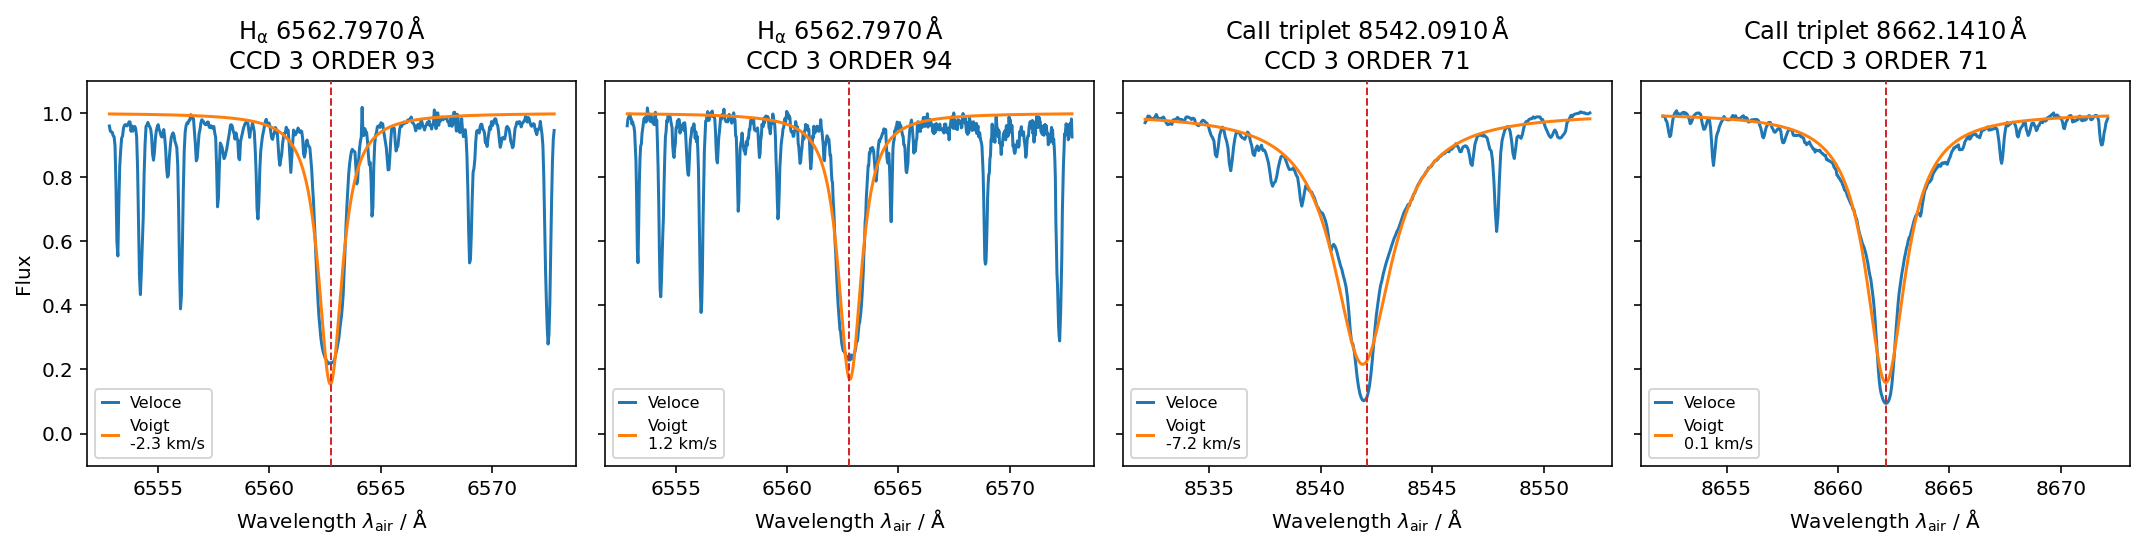

  -> Creating overview PDF. This may take some time for the 109 orders.
  -> Succesfully calibrated wavelength with diagnostic plots for HIP69673


In [7]:
for science_object in list(science_runs.keys()):
    try:
        VR.calibration.calibrate_wavelength(science_object, correct_barycentric_velocity=True, create_overview_pdf=True)
        print('  -> Succesfully calibrated wavelength with diagnostic plots for '+science_object)
    except:
        print('  -> Failed to calibrate wavelength for '+science_object)